**Training and Validation set generator for LANL Earthquake Prediction**

Generates list of start rows in train.csv which can be used for creating training and validation data

* Sets can be created in a way that they are approximate of a specific histogram of y ('time_to_failure') 
* Samples overlap adjustable from 0 to 150,000 rows
* Samples with "Earthquakes" are excluded
* Optional exclusion list of samples (good for example to exclude validation data from training set)
* 150,000 rows samples assumed

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

Seed set for testing only

In [17]:
np.random.seed(3)

To load full train.csv, comment first and uncomment second line

In [18]:
raw_train_data = pd.read_csv ('../input/train.csv', nrows=100000000,dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})
#raw_train_data = pd.read_csv ('../input/train.csv',dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

**The generator itself**

* **input_list** is numpy array from the train.csv (raw_train_data.values)

* **set_size** is number of samples in the set

* **max_overlap** is the highest allowed overlap in rows, set to zero if no overlap is requested. My humble opinion is that train data can overlap, validation data should not. **Note:** The max_overlap = 0 setting restrics dramatically number of possible samples, thus some data sets can't be created! Currently there is no protection for endless loop due to shortage of samples with specific criteria combination (overlap, no earthquake, specific histogram and set size) **Start with small sets!**

* **histogram** is the required distribution of y. Please note that the histogram is required to be in whole second intervals. I think it's sufficient "detail" for the moment

* **exclusions** is list of start rows which shall be excluded from the set - I use it to exclude validation data from train set, but it can be used to exclude specific sections of train.csv if required. Exclusions are always 150,000 rows long.

In [19]:
def generate_data_set (input_list,set_size,max_overlap=0,histogram=[],exclusions=[]):
# input_list - numpy array(?,2) of train data
# set_size - number of samples in the data set
# overlap - define max overlap in rows (150000=100%)
# histogram - target (y-)histogram for the data set (in 1 second steps). If [], random distribution
# exclusions - array of index of samples to be excluded (eg. to generate more mutually exclusive validation sets) 
#              Use with care! There is a limited number of possibilites to create validation sets with specific 
#              histogram. There is no protection against endless loop built in!


    i=0
    m=input_list.shape[0]
    index=[]

    if histogram!=[]:
        data_size=np.sum(histogram[0])
        set_hist=np.round(histogram[0]/data_size*set_size)
    else:
        data_size=17        
        set_hist=np.zeros((17,))
        set_hist[:]=set_size

#    print ("Set buckets shape "+str(set_hist.shape))
#    print ("Expected buckets\n"+str(set_hist))
    if np.sum(set_hist)!=set_size:             # Correction for rounding errors
        set_hist[0]=set_hist[0]-(np.sum(set_hist)-set_size)
    set_bucket=np.zeros(set_hist.shape[0])
    set_full=np.zeros(set_hist.shape[0])         
    set_full[set_hist==0]=1.                    # When histogram bucket is empty, it is actually already full
    for j in tqdm(range (0,set_size)):
        while True:
            start = np.int(np.random.rand()*(m-150000)) #reduced length by 150000 to avoid to hit prematurelly end
#            print ("Start "+str(start))
            overlap=False                               #test for overlap > max_overlap between samples
            for i in index:
                if (150000-np.abs(start-i)) > max_overlap:
#                    print ("overlap of "+str(150000-np.abs(start-i))+" detected at "+str(i)+" with "+str(start))
                    overlap=True
                    break
            if overlap:
                continue 
            exclude=False
            for i in exclusions:
                if (150000-np.abs(start-i))>0:
#                    print ("In exclusion list "+str(i)+" with "+str(start))
                    overlap=True
                    break
            if overlap:
                continue 
            x=input_list[start:start+150000]
            if np.max(x[1:,1]-x[:-1,1]) > 1:           #testing for earthquake within the sample
#                print ("earthquake within sample")
                continue  
            y=np.average(x[:,1])   
            y_int=int(np.floor(y))
            
            if set_full[y_int]:                 #testing if we need this y - does it fit to histogram?
#                print ("Bucket "+str(y_int)+" full")
                continue
            # If we reached it here, we should have a valid sample
#            print ("valid sample "+str(start)+" with y "+str(y))
            set_bucket[y_int]=set_bucket[y_int]+1
#            print (set_bucket)
            if set_bucket[y_int]==set_hist[y_int]:
#                print ("Bucket "+str(y_int)+" full")
                set_full[y_int]=1
            break
        index.append(start)
#    print ("Final buckets\n"+str(set_bucket))
    return index

**Here couple of examples:**

First we create histogram of the train.csv

In [20]:
train_data_hist=np.histogram(raw_train_data['time_to_failure'].values,
                             bins=range(int(np.floor(raw_train_data['time_to_failure'].values.min())),
                                        int(np.ceil(raw_train_data['time_to_failure'].values.max()))+1))
print (train_data_hist)

(array([7700478, 8679653, 7692331, 7700479, 7700478, 7700479, 7700478,
       7700479, 7700053, 7692712, 7700478, 5935104, 3850239, 3850239,
        696320]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))


3 validation sets with different parameters

In [21]:
validation_set=np.zeros((3,64),dtype=int)

Random validation set of 64 samples

In [22]:
validation_set[0,:] = generate_data_set(raw_train_data.values,64)

100%|██████████| 64/64 [00:00<00:00, 2942.31it/s]


Validation set according the train.csv distribution of 'time_to_failure'. Note: the example is on reduced set of 100,000,000 rows 

In [23]:
validation_set[1,:] = generate_data_set(raw_train_data.values,64,histogram=train_data_hist)

100%|██████████| 64/64 [00:00<00:00, 1542.49it/s]


Same as before, but all samples from the previous set are excluded

In [24]:
validation_set[2,:] = generate_data_set(raw_train_data.values,64,histogram=train_data_hist,
                                              exclusions=validation_set[1,:])

100%|██████████| 64/64 [00:00<00:00, 1016.71it/s]


Train data set, with validation set 1 excluded. Overlap of max 50% (75,000 rows) between samples is allowed.

In [25]:
train_data = generate_data_set(raw_train_data.values,500,histogram=train_data_hist,exclusions=validation_set[1,:],
                              max_overlap=75000)

100%|██████████| 500/500 [00:00<00:00, 538.34it/s] 


**Histograms to show the distbution of 'time_to_failure'**

(array([7700478., 8679653., 7692331., 7700479., 7700478., 7700479.,
        7700478., 7700479., 7700053., 7692712., 7700478., 5935104.,
        3850239., 3850239.,  696320.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

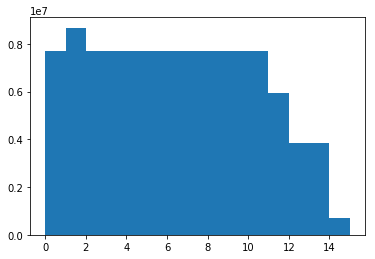

In [26]:
plt.hist(raw_train_data['time_to_failure'].values,
         bins=range(int(np.floor(raw_train_data['time_to_failure'].values.min())),
                    int(np.ceil(raw_train_data['time_to_failure'].values.max()))+1))

This is our 500 samples trainig set

(array([35., 44., 39., 38., 39., 40., 38., 40., 38., 39., 37., 31., 20.,
        19.,  3.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

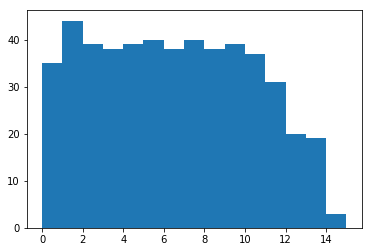

In [27]:
plt.hist(raw_train_data['time_to_failure'].values[train_data],
         bins=range(int(np.floor(raw_train_data['time_to_failure'].values.min())),
                    int(np.ceil(raw_train_data['time_to_failure'].values.max()))+1))

Validation set 0 - fully random, so no big match with the training set

(array([6., 6., 4., 5., 4., 5., 4., 7., 3., 7., 4., 3., 3., 3., 0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

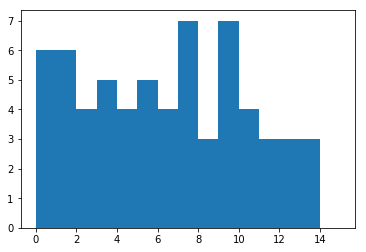

In [28]:
plt.hist(raw_train_data['time_to_failure'].values[validation_set[0,:]],
         bins=range(int(np.floor(raw_train_data['time_to_failure'].values.min())),
                    int(np.ceil(raw_train_data['time_to_failure'].values.max()))+1))

Validation set 1 - approximation of the training set distribution with 64 samples

(array([5., 6., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 2., 2., 0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

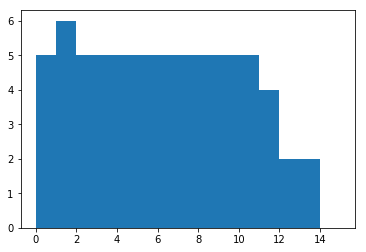

In [29]:
plt.hist(raw_train_data['time_to_failure'].values[validation_set[1,:]],
         bins=range(int(np.floor(raw_train_data['time_to_failure'].values.min())),
                    int(np.ceil(raw_train_data['time_to_failure'].values.max()))+1))

Validation set 2 - Another approximation of the training set distribution with 64 samples, independent from Validation set 1

(array([5., 6., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 2., 1., 1.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

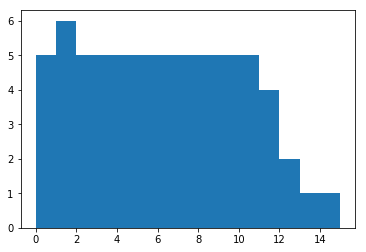

In [30]:
plt.hist(raw_train_data['time_to_failure'].values[validation_set[2,:]],
         bins=range(int(np.floor(raw_train_data['time_to_failure'].values.min())),
                    int(np.ceil(raw_train_data['time_to_failure'].values.max()))+1))